# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd
import shap

# Reading data and pre-processing

In [3]:
# loading csv
df = pd.read_csv('predictions/train_predictions_fwd.csv')

In [4]:
# removing unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.columns

Index(['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 'Start',
       'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'Att.1', 'Succ',
       'Match Report', 'Name', 'Season', 'WDL', 'GoalsTeams', 'Team Score',
       'Opp Score', 'CS', 'Was Home', 'GW', 'FPL', 'neutral_name',
       'Total Points', 'FPL position', 'Opp rating', 'ScoreForLast5',
       'ScoreAgainstLast5', 'Points'],
      dtype='object')

In [35]:
df["Name"].unique()

array(['Che-Adams', 'Michail-Antonio', 'Adam-Armstrong', 'Taiwo-Awoniyi',
       'Patson-Daka', 'Emmanuel-Dennis', 'Joe-Gelhardt', 'Sam-Greenwood',
       'Kai-Havertz', 'Kelechi-Iheanacho', 'Danny-Ings',
       'Brennan-Johnson', 'Sekou-Mara', 'Neal-Maupay', 'Bryan-Mbeumo',
       'Aleksandar-Mitrovic', 'Kieffer-Moore', 'Eddie-Nketiah',
       'Gianluca-Scamacca', 'Dominic-Solanke', 'Sam-Surridge',
       'Ivan-Toney', 'Deniz-Undav', 'Jamie-Vardy', 'Carlos-Vinicius',
       'Ollie-Watkins', 'Danny-Welbeck', 'Callum-Wilson', 'Chris-Wood'],
      dtype=object)

In [6]:
df.shape

(258, 53)

In [7]:
# dropping NaNs
# df = df.dropna(axis=0)

In [8]:
df.shape

(258, 53)

In [34]:
df[df["Name"] == "Erling-Haaland"]

,Date,Day,Comp,Round,Venue,Squad,Opponent,Start,Pos,Min,...,Was Home,GW,FPL,neutral_name,Total Points,FPL position,Opp rating,ScoreForLast5,ScoreAgainstLast5,Points


<AxesSubplot:>

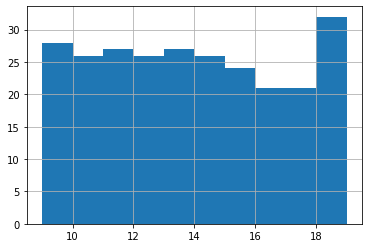

In [10]:
df["GW"].hist()

# Choosing features and splitting data

In [11]:
features = ["Points", "Was Home", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5']
info = ["Name", "GW", "Squad", "Opponent", "Was Home", "Opp rating"]
to_predict = ["Total Points"]

In [12]:
GAMEWEEK_TO_PREDICT = 19

In [13]:
# gameweeks 9-14 is training data, gw 15 is test data
X_train = df[(df["GW"] >= 9) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1)][features]
y_train = df[(df["GW"] >= 9) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1)][to_predict]

In [14]:
X_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][features]
y_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][to_predict]

In [15]:
X_train.size, y_train.size, X_test.size, y_test.size

(1225, 245, 65, 13)

# Model

In [16]:
model = xgb.XGBRegressor()

In [17]:
%%time
model.fit(X_train, y_train)

CPU times: total: 359 ms
Wall time: 105 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [18]:
# make predictions on the test data
predictions = model.predict(X_test)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# calculate the MAE and MSE scores
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

In [20]:
print("MAE: ", mae)
print("MSE: ", mse)

MAE:  2.2352946354792667
MSE:  9.807063691722202


# Predictions

In [21]:
X_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][features]
y_test = df[df["GW"] == GAMEWEEK_TO_PREDICT][to_predict]

In [22]:
df_predictions = df[df["GW"] == GAMEWEEK_TO_PREDICT]

In [23]:
df_predictions.shape

(13, 53)

In [24]:
len(predictions)

13

In [25]:
df_predictions["pred"] = predictions


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

Boolean Series key will be reindexed to match DataFrame index.


array([], shape=(0, 0), dtype=float32)

In [27]:
df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
140,Bryan-Mbeumo,19,Brentford,Liverpool,1.0,2006.804077,12.0,7.905613
111,Brennan-Johnson,19,Nott'ham Forest,Southampton,0.0,1658.088989,4.0,7.823110
257,Chris-Wood,19,Newcastle Utd,Arsenal,0.0,1934.447754,1.0,7.231625
148,Aleksandar-Mitrovic,19,Fulham,Leicester City,0.0,1770.339966,5.0,3.989887
10,Che-Adams,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,3.092796
169,Eddie-Nketiah,19,Arsenal,Newcastle Utd,1.0,1850.296631,1.0,2.971339
234,Ollie-Watkins,19,Aston Villa,Wolves,1.0,1686.353516,2.0,2.898656
20,Michail-Antonio,19,West Ham,Leeds United,0.0,1712.961670,1.0,2.070609
31,Adam-Armstrong,19,Southampton,Nott'ham Forest,1.0,1630.994873,1.0,1.758899
100,Danny-Ings,19,Aston Villa,Wolves,1.0,1686.353516,8.0,1.108831


# Feature importance and influence

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

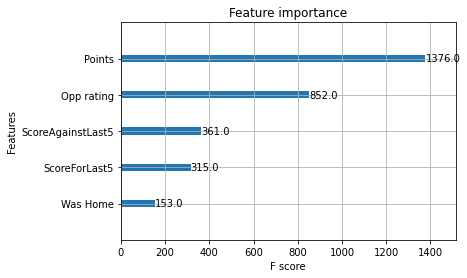

In [28]:
plot_importance(model)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


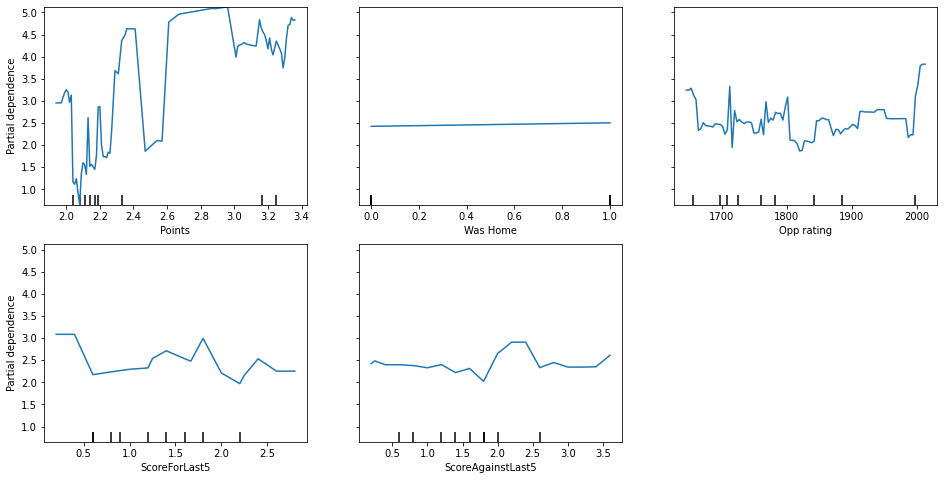

In [29]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_partial_dependence(model, X_train, features, ax=ax)

In [30]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

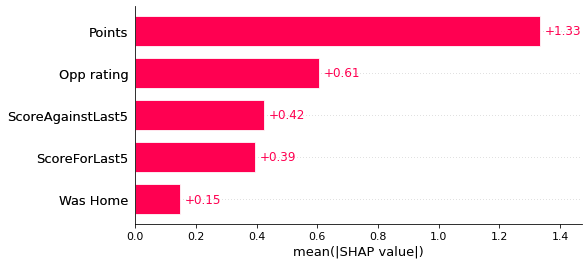

In [31]:
shap.plots.bar(shap_values)

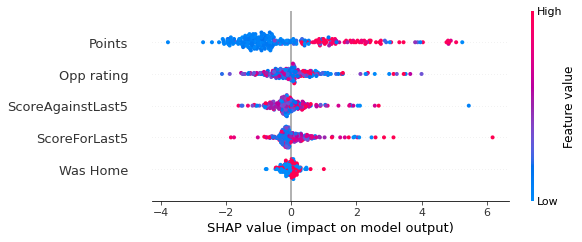

In [32]:
shap.plots.beeswarm(shap_values)

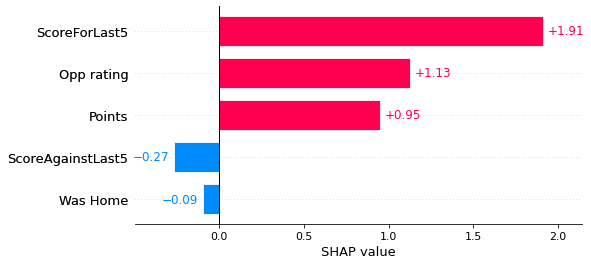

In [33]:
shap.plots.bar(shap_values[3])